<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 2: Variational Autoencoders
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [ ]:
Name = "fariborz kohanzad"
StudentId = "400103613"

In [2]:
import numpy as np
from tqdm import tqdm
from tqdm import trange
from matplotlib import pyplot as plt
import math

import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset

In [3]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


# Dataset (5 points)

Download the MNIST dataset and merge the train and test datasets for training the generative model.

In [4]:
# TODO: Define transformations
transform = transforms.Compose([
     transforms.PILToTensor(),
     transforms.ConvertImageDtype(torch.float), ])

# Load train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Merge the two datasets to train the model on the images.

In [5]:
# TODO: Concatenate train and test datasets
merged_dataset = ConcatDataset([train_dataset, test_dataset])
merged_loader = DataLoader(merged_dataset, batch_size=64, shuffle=True)

print(f'The size of the merged dataset is {len(merged_loader.dataset)}')

The size of the merged dataset is 70000


# EDA (10 points)

Plot the distribution of each class in the dataset.

In [6]:
def plot_class_distribution(dataloader):
    # TODO: Initialize a dictionary to count occurrences of each class
    class_counts = {}
    class_labels = []
    # TODO: Iterate through the DataLoader to count the labels
    for images, labels in dataloader:
        for label in labels:
            if label.item() not in class_counts:
                class_counts[label.item()] = 0
            class_counts[label.item()] += 1
    # TODO: Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values() , edgecolor='black')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.show()


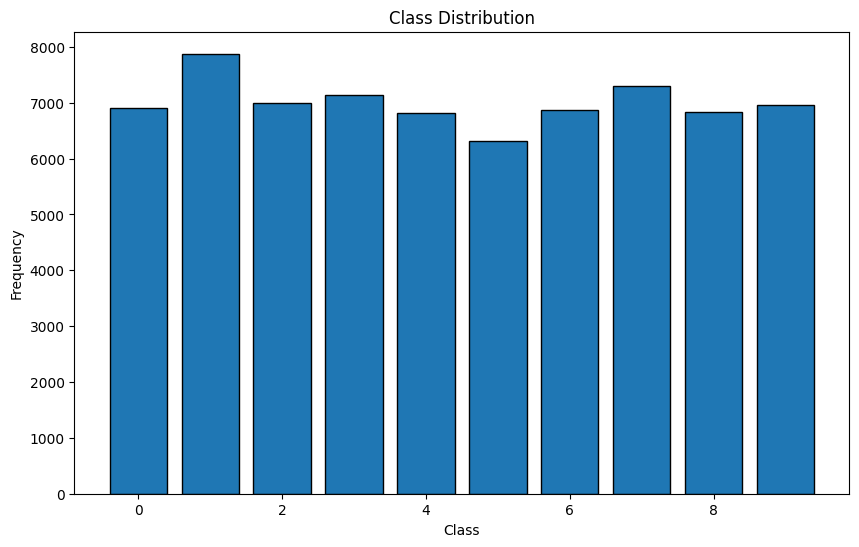

In [7]:
plot_class_distribution(merged_loader)

Plot the average of each class in the dataset.

In [8]:
def plot_class_averages(dataloader):
    # TODO: Iterate over the DataLoader to accumulate sums and counts
    class_sums = {}
    class_counts = {}
    for images, labels in dataloader:
        for label, image in zip(labels, images):
            if label.item() not in class_sums:
                class_sums[label.item()] = torch.zeros_like(image)
                class_counts[label.item()] = 0
            class_sums[label.item()] += image
            class_counts[label.item()] += 1

    # TODO: Calculate the average images for each class
    class_averages = {}
    for label, image_sum in class_sums.items():
        class_averages[label] = image_sum / class_counts[label]

    # TODO: Plot the averages
    plt.figure(figsize=(10, 10))
    for label, image in class_averages.items():
        plt.subplot(5, 5, label + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Class {label}')
    plt.tight_layout()
    plt.show()


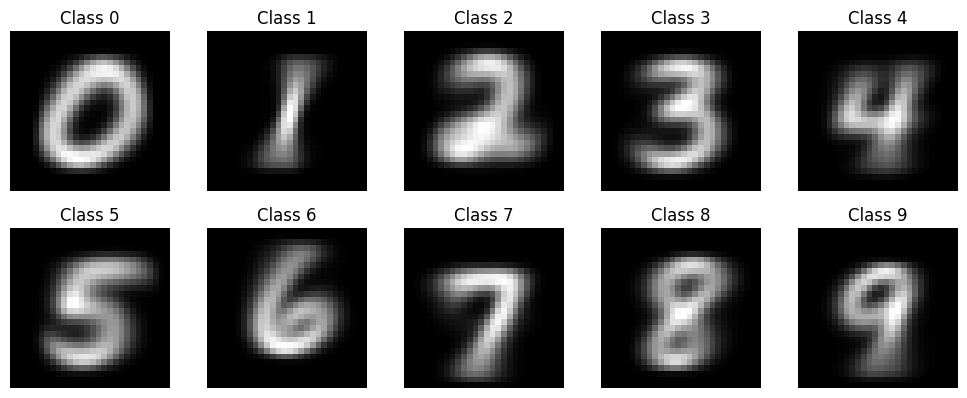

In [9]:
plot_class_averages(merged_loader)

# Variational Autoencoder (25 points)

In [10]:
class VAE(nn.Module):

    def __init__(self, latent_dim=2):
        # TODO
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder Layers
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc_mean = nn.Linear(512, self.latent_dim)
        self.fc_var = nn.Linear(512, self.latent_dim)

        # Decoder Layers
        self.fc3 = nn.Linear(self.latent_dim, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 28 * 28)
        self.sigmoid = nn.Sigmoid()


    def encode(self, x):
        # TODO
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        var = self.fc_var(x)
        return mean, var


    def reparameterization(self, mean, var):
        # TODO
        var = torch.exp(0.5 * var)
        sample = torch.randn_like(var , device=mean.device)
        return sample * var + mean


    def decode(self, x):
        # TODO
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return self.sigmoid(x)


    def forward(self, x):
        # TODO
        mean, var = self.encode(x)
        x = self.reparameterization(mean, var)
        x = self.decode(x)
        return x , mean, var

In [11]:
model = VAE(latent_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

# Training (20 points)

Define the loss function for training the VAE. The loss functions should be a combination of the reconstruction loss and the KL-divergence loss. You can choose to increase the weight of these losses to achieve better results.

In [12]:
def loss_function(x, x_hat, mean, log_var):
    # TODO
    x = x.view(-1, 28 * 28)
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence


Now you must train your network using the loss function you defined earlier. Make sure to plot and monitor the training loss over epochs.

In [15]:
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('VAE Training Loss Over Epochs')
    plt.legend()
    plt.show()


def train(model, optimizer, n_epochs=50, losses=losses):
    # TODO
    model.train()
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0
        for batch_idx, (data, _) in enumerate(merged_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mean, log_var = model(data)
            loss = loss_function(data, recon_batch, mean, log_var)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        average_loss = epoch_loss / len(merged_loader.dataset)
        losses.append(average_loss)
    print(f'The final loss: {losses[-1]}')
    return losses


100%|██████████| 50/50 [10:53<00:00, 13.07s/it]


The final loss: 135.44716067940848


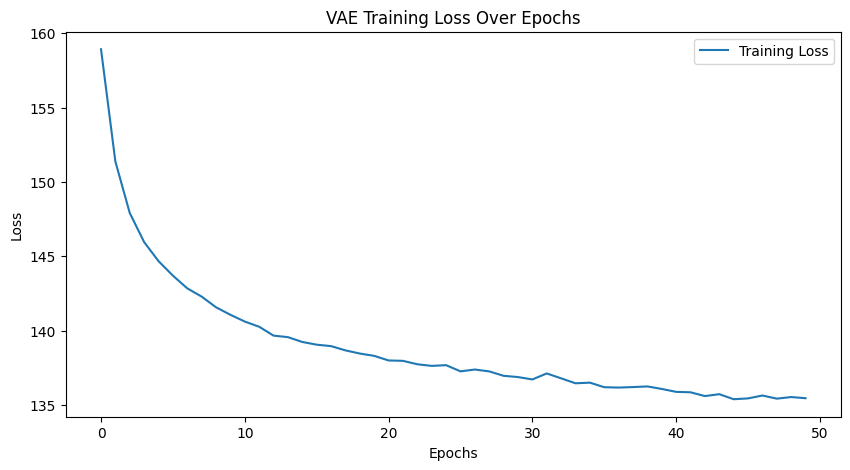

In [16]:
losses = train(model, optimizer)
plot_losses(losses)

# The Encoder (20 points)

Let's first take a look at the encoder. Start by visualizing the latent dimension for the merged dataset.

In [17]:
def visualize(vae, dataloader, batch_count=50, title='Latent Space Visualization'):
    vae.eval()
    latent_representations = []
    labels = []

    # Iterate over the dataloader
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            if i >= batch_count:
                break

            x = x.to(next(vae.parameters()).device)
            y = y.to(next(vae.parameters()).device)

            x = x.view(x.size(0), -1)
            mu, logvar = vae.encode(x)
            latent_representations.append(mu)
            labels.append(y)

    # Stack all latent representations and labels
    latent_representations = torch.cat(latent_representations)
    labels = torch.cat(labels)

    latent_representations = latent_representations.cpu().numpy()
    labels = labels.cpu().numpy()

    # Plot the latent space
    plt.figure(figsize=(11, 8))
    scatter = plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c=labels, cmap='tab10', alpha=1)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

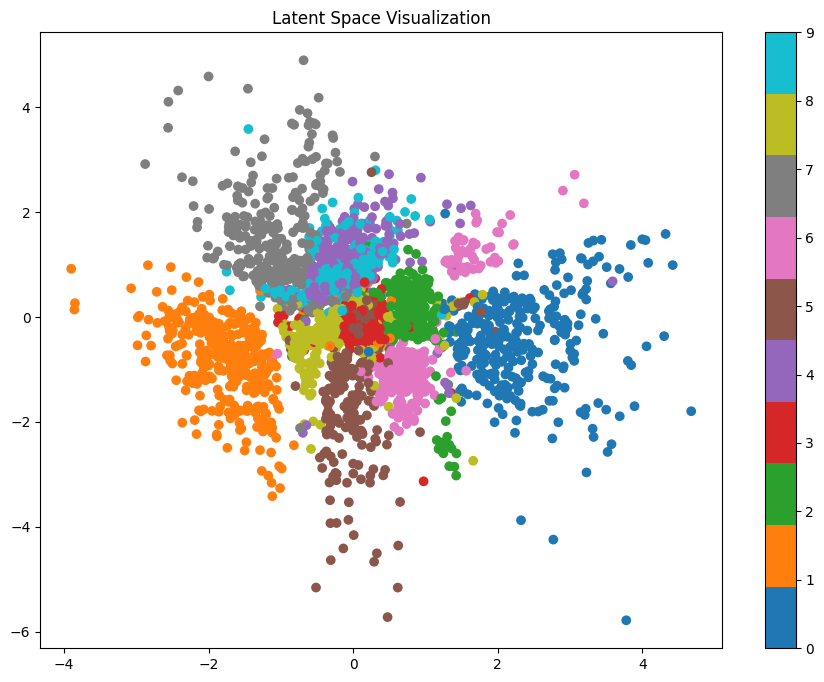

In [18]:
visualize(model, merged_loader)

Imagine if the input data for the encoder followed a very different distribution. Invert the images in the original datset and plot the latent dimension once more to show the difference.

In [24]:
def inverted_visualize(vae, dataloader, batch_count=50, title='Latent Space Visualization'):
    # TODO: Iterate over the inverted dataloader and plot the latent space
    vae.eval()
    latent_representations = []
    labels = []

    # Iterate over the dataloader
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            if i >= batch_count:
                break

            x = x.to(next(vae.parameters()).device)
            y = y.to(next(vae.parameters()).device)

            x = x.view(x.size(0), -1)

            x = 1 - x

            mu, logvar = vae.encode(x)
            latent_representations.append(mu)
            labels.append(y)

    # Stack all latent representations and labels
    latent_representations = torch.cat(latent_representations)
    labels = torch.cat(labels)

    latent_representations = latent_representations.cpu().numpy()
    labels = labels.cpu().numpy()

    # Plot the latent space
    plt.figure(figsize=(11, 8))
    scatter = plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c=labels, cmap='tab10', alpha=1)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

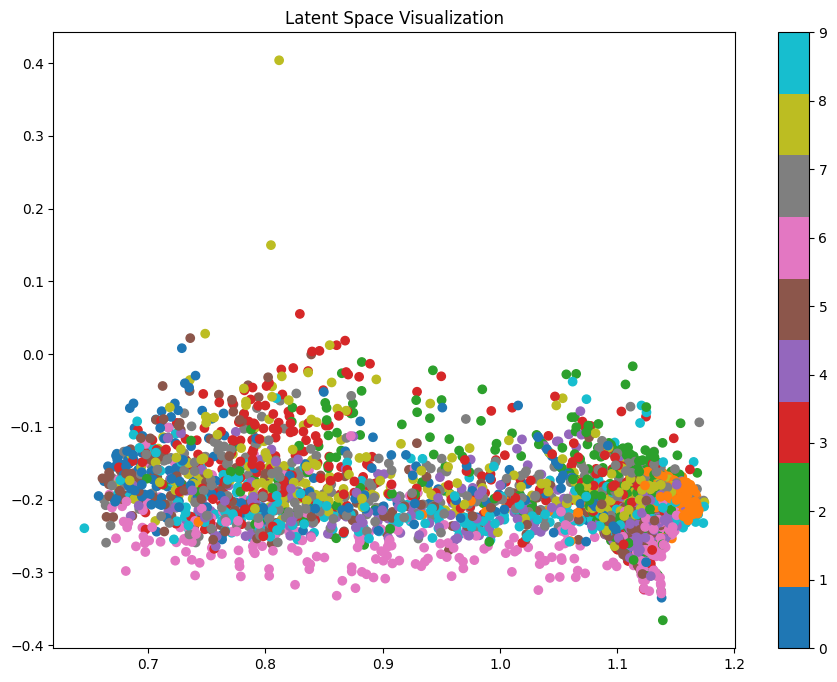

In [25]:
inverted_visualize(model, merged_loader)

Explain how the difference in the latent dimension allows us to detect data samples that don't follow the original distribution. How can this difference be used for anomaly detection? If we had used an autoencoder instead, what would be our observation then?

*`Your Answer:`*

During training, the VAE learns to represent the distribution of normal data points within this latent space. When a new data sample is passed through the encoder, it is mapped to a point in this space. If the sample belongs to the same distribution as the training data, the VAE will generate a latent representation close to the typical region in the latent space. However, if the sample is anomalous, its latent representation will likely fall outside the typical region. This results in:

**High Reconstruction Error**: Anomalous samples tend to have high reconstruction errors because the VAE cannot effectively reconstruct data points that differ significantly from the training distribution.

**Low Latent Space Probability**: The VAE assigns a low probability to samples that fall far from the learned distribution in the latent space, providing another signal of anomaly.

Thus, we can use a threshold on the reconstruction error or the probability in the latent space to detect anomalies.

### Comparison to an Autoencoder (AE)

In a traditional autoencoder, the model directly minimizes the reconstruction error without imposing a specific distribution in the latent space. Therefore:

**No Probability Interpretation**: An AE doesn’t encourage the latent space to follow any specific distribution, so we can’t assign probabilities to detect whether a sample belongs to the original data distribution.

**Reconstruction-Based Detection**: We would rely solely on reconstruction error to detect anomalies. A high reconstruction error would indicate an anomaly, but this approach is less robust than using a VAE, as it lacks the probabilistic guidance of the latent space distribution.

# The Decoder (20 points)

In this section we are going to test the properties of the decoder. First implement a function to create samples based on the input mean and variance.

In [21]:
def generate_digit(mean, var):
    # TODO: Return the generated image
    std = torch.exp(0.5 * var)
    epsilon = torch.randn_like(std)
    z = mean + epsilon * std
    with torch.no_grad():
        generated_image = model.decode(z).cpu()
    return generated_image.view(28, 28)

Now using this function plot the decoded output sampled from a uniform distribution from -1 to +1.

In [22]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # TODO: Display a n*n 2D manifold of digits and construct a grid
    plt.figure(figsize=(figsize, figsize))

    grid_x = torch.linspace(-scale, scale, n)
    grid_y = torch.linspace(-scale, scale, n)

    # TODO: Generate images for the grid
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.tensor([[xi, yi]], device=next(model.parameters()).device)

            with torch.no_grad():
                generated_image = model.decode(z)
                generated_image = generated_image.view(digit_size, digit_size)
                generated_image = torch.sigmoid(generated_image).cpu().numpy()

            # Ploting
            ax = plt.subplot(n, n, i * n + j + 1)
            ax.imshow(generated_image, cmap="gray")
            ax.axis("off")

    # TODO: Display the results
    plt.suptitle("VAE Latent Space Visualization", fontsize=16)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

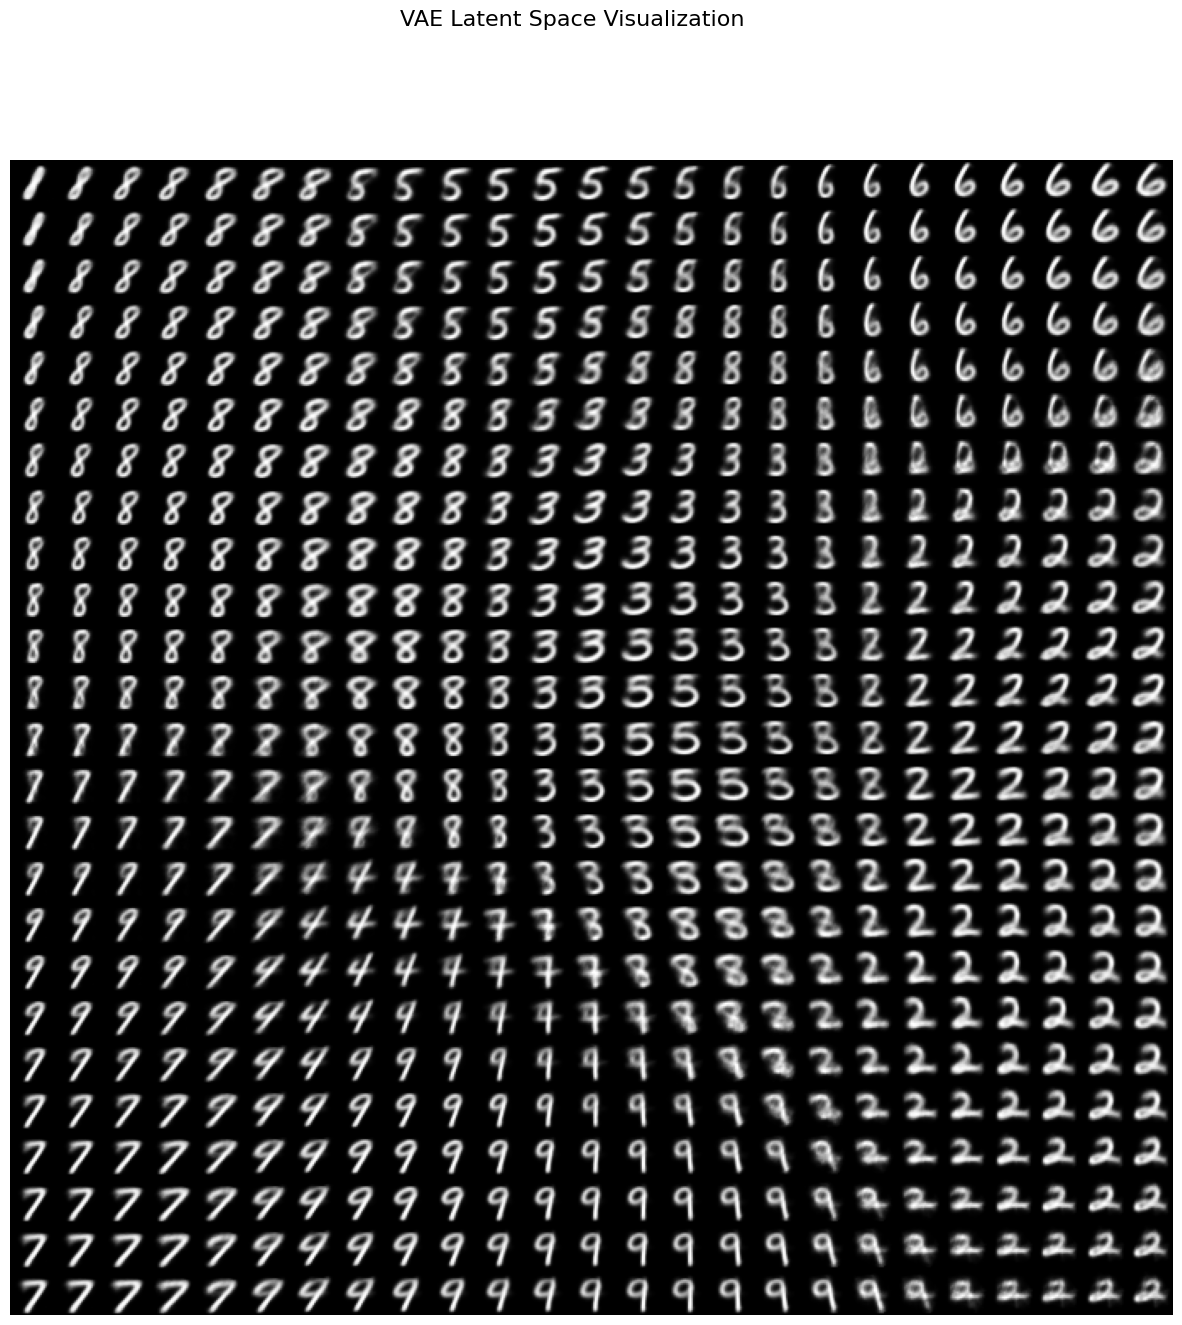

In [23]:
plot_latent_space(model)

What happens when you sample from regions outside the aformentioned space? Why? What could we expect if the network was not a variational autoencoder, but a simple autoencoder instead?

*`Your Answer:`*

As was said in the previous part, the regions outside the aformentioned space are regions with low propability and high reconstrction error, meaning that they are not meaningful. So if we sample from outside the most-mapped-to section we'll get a meaningless image.

In case of an autoencoder, because there is no latent distribution and latent representations are not concerated around a distribution we can expect a meaningful image when we sample from outside of the main region. but it's ot guaranteed.